# 데이터 준비하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import requests
from summa.summarizer import summarize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib.request
import warnings
warnings.filterwarnings('ignore', category = UserWarning, module = 'bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
90286,New trailer of Christopher Nolan's 'Dunkirk' r...,A new trailer of Christopher Nolan's upcoming ...
25457,"Bullies to be put in their place, that's what ...","Actress Kangana Ranaut, while talking about be..."
36857,"Chanda Kochhar to lose Ã¢ÂÂ¹9.8 crore bonus, ...",After ICICI Bank sacked former CEO Chanda Koch...
87469,Flipkart CEO Krishnamurthy takes up additional...,Flipkart CEO Kalyan Krishnamurthy has taken ad...
51248,BigBasket to invest Ã¢ÂÂ¹500 crore in farmer ...,Online grocery store BigBasket will invest up ...
59004,Ronaldo honoured with new bust at Real Madrid ...,Real Madrid forward and Portuguese captain Cri...
73381,Amitabh Bachchan is the most gifted comedian: ...,Filmmaker Sajid Khan has said Amitabh Bachchan...
46124,Jacqueline plays Hallelujah on piano as tribut...,Jacqueline Fernandez paid tribute to late actr...
49888,Facebook sued by family of man whose murder wa...,Facebook has been sued in the US for negligenc...
86746,Twinkle reacts to HC judge remark on peacocks ...,"Novelist Twinkle Khanna, responding to Rajasth..."


# 데이터 전처리

In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수: ', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수: ', data['text'].nunique())
# 데이터의 중복값 제거

headlines 열에서 중복을 배제한 유일한 샘플의 수:  98280
text 열에서 중복을 배제한 유일한 샘플의 수:  98360


In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수: ', (len(data)))

전체 샘플수:  98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수: ', (len(data)))
# 데이터의 결측치 제거

전체 샘플수:  98360


In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
# 영어에서 같은 뜻을 의미하는 줄임말들 사전 

정규화 사전의 수:  120


In [9]:
print('불용어 개수: ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
        # text의 불용어 제거
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        # headlines는 불용어를 제거하지 않음
    return tokens

In [11]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace = True)

In [14]:
data.isnull().sum()
data.dropna(axis = 0, inplace = True)

# 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이: 1
텍스트의 최대 길이: 60
텍스트의 평균 길이: 35.09968483123221
요약의 최소 길이: 1
요약의 최대 길이: 16
요약의 평균 길이: 9.299532330215534


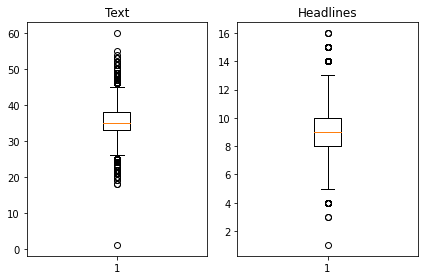

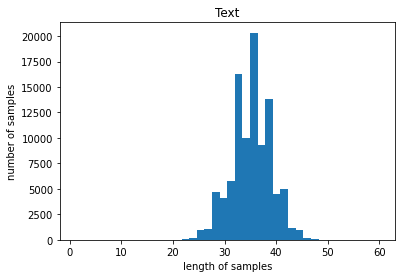

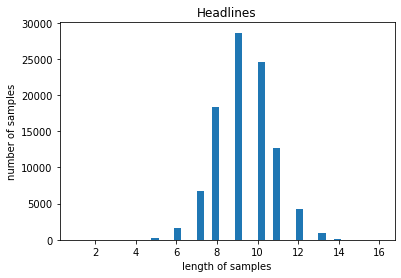

In [15]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이: {}'.format(np.min(text_len)))
print('텍스트의 최대 길이: {}'.format(np.max(text_len)))
print('텍스트의 평균 길이: {}'.format(np.mean(text_len)))
print('요약의 최소 길이: {}'.format(np.min(headlines_len)))
print('요약의 최대 길이: {}'.format(np.max(headlines_len)))
print('요약의 평균 길이: {}'.format(np.mean(headlines_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1, 2, 2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 데이터의 텍스트와 요약 최소, 최대, 그리고 평균 길이를 그래프로 표현 

In [16]:
text_max_len = 40
headlines_max_len = 10

In [17]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            count += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수: ', (len(data)))

전체 샘플수:  74102


In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x: x +' eostoken')
data.head()
# decoder_input과 decoder_output을 새로 생성

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [21]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수: ', len(encoder_input_train))
print('훈련 레이블의 개수: ', len(decoder_input_train))
print('테스트 데이터의 개수: ', len(encoder_input_test))
print('테스트 레이블의 개수: ', len(decoder_input_test))
# train_data와 test_data로 데이터를 분할

훈련 데이터의 개수:  59282
훈련 레이블의 개수:  59282
테스트 데이터의 개수:  14820
테스트 레이블의 개수:  14820


# 정수 인코딩

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)

In [26]:
threshold = 7
total_count = len(src_tokenizer.word_index)
rare_count = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_count += 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기: ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_count - rare_count))
print('단어 집합에서 희귀 단어의 비율: ', (rare_count / total_count) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  61568
등장 빈도가 6번 이하인 희귀 단어의 수: 42321
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19247
단어 집합에서 희귀 단어의 비율:  68.73863045738045
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  4.200268243405764


In [27]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
# 텍스트 시퀸스를 정수 시퀸스로 변환

In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
threshold = 6
total_count = len(tar_tokenizer.word_index)
rare_count = 0
total_freq = 0 
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_count += 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기: ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold-1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_count - rare_count))
print('단어 집합에서 희귀 단어의 비율: ', (rare_count / total_count) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  27345
등장 빈도가 5번 이하인 희귀 단어의 수: 18340
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9005
단어 집합에서 희귀 단어의 비율:  67.06893399158895
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  6.030628549460319


In [30]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀸스를 정수 시퀸스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3958, 63, 9, 96, 6492, 5114, 6, 69, 341, 624], [1, 507, 857, 612, 1384, 12, 2470, 4663], [1, 23, 21, 3, 923, 5, 5386, 959, 6, 832], [1, 4664, 468, 7, 71, 1934, 1175], [1, 27, 1543, 236, 303, 30, 3, 247, 549, 2864]]
target
decoder  [[3958, 63, 9, 96, 6492, 5114, 6, 69, 341, 624, 2], [507, 857, 612, 1384, 12, 2470, 4663, 2], [23, 21, 3, 923, 5, 5386, 959, 6, 832, 2], [4664, 468, 7, 71, 1934, 1175, 2], [27, 1543, 236, 303, 30, 3, 247, 549, 2864, 2]]


In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


In [32]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding = 'post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding = 'post')

# 모델 설계

In [33]:
# 인코더 설계
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape = (text_max_len))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, stat_c1 = encoder_lstm1(enc_emb)
# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [34]:
# 디코더 설계
decoder_inputs = Input(shape = (None, ))
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

In [35]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [36]:
# 어텐션 함수
attn_layer = AdditiveAttention(name = 'attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# Model Training

In [37]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 157s 543ms/step - loss: 6.3050 - val_loss: 5.8652
Epoch 2/50
232/232 [==============================] - 125s 541ms/step - loss: 5.7554 - val_loss: 5.5466
Epoch 3/50
232/232 [==============================] - 122s 527ms/step - loss: 5.4284 - val_loss: 5.2715
Epoch 4/50
232/232 [==============================] - 122s 524ms/step - loss: 5.1575 - val_loss: 5.0710
Epoch 5/50
232/232 [==============================] - 123s 530ms/step - loss: 4.9196 - val_loss: 4.9057
Epoch 6/50
232/232 [==============================] - 123s 531ms/step - loss: 4.7189 - val_loss: 4.7785
Epoch 7/50
232/232 [==============================] - 123s 531ms/step - loss: 4.5477 - val_loss: 4.6814
Epoch 8/50
232/232 [==============================] - 122s 526ms/step - loss: 4.3995 - val_loss: 4.5942
Epoch 9/50
232/232 [==============================] - 121s 520ms/step - loss: 4.2627 - val_loss: 4.5301
Epoch 10/50
232/232 [==============================] - 120s 516m

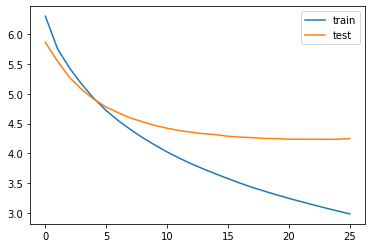

In [38]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [39]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [40]:
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])
# 이전 시점의 상태를 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size, ))
decoder_state_input_c = Input(shape = (hidden_size, ))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

In [41]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Model Test

In [56]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [57]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hind mere jind first song sachin billion dreams upcoming biopic former cricketer sachin tendulkar released monday occasion th birthday song composed sung oscar winning music composer ar rahman lyrics irshad kamil directed james biopic scheduled release may 
실제 요약 : st song from sachin biopic released on his th birthday 
예측 요약 :  sachin tendulkar to attend debut in his biopic


원문 : actress janhvi kapoor honoured rising talent year award norwegian consulate general recognition pleasant surprise happy receive honour humbled chose honour actress said janhvi made bollywood debut dhadak year 
실제 요약 : janhvi to get rising talent award from consulate 
예측 요약 :  janhvi kapoor features on kapoor cover of filmfare show


원문 : us based company developed pillow hybrid responds users body heat thus preventing priced nearly pillow adjusts users move allowing trapped air surface stays cool pillow covered material originally developed nasa protect astronauts temperature variations 
실제 요약 : uses na

# 추출적 요약 해보기

In [45]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [46]:
print('Summary: ')
print(summarize(text, ratio = 0.005))

Summary: 
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [47]:
print('Summary: ')
print(summarize(text, ratio = 0.005, split = True))

Summary: 
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [48]:
print('Summary: ')
print(summarize(text, words = 50))

Summary: 
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


결과: Extractive 요약을 해보니 요약이라기 보다는 그냥 문장을 가져다가 복사하는 수준이라고 할 수 있고 오히려 Abstractive 요약이 틀린 경우가 있더라도 요약에 가까운 모습을 보여줌